In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.datasets import WebKB

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
dataset = WebKB(root='data/WebKB', name='Cornell')              #(Cornell, Texas, Wisconsin, Washington)
print(f"Dataset loaded: {dataset}")

Dataset loaded: cornell()


In [4]:
def analyze_dataset(dataset):
    data = dataset[0]
    
    print("Dataset Analysis:")
    print(f"    ")
    
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {dataset.num_classes}")
    
    print("\nNode feature matrix shape:", data.x.shape)
    print("Edge index shape:", data.edge_index.shape)
    
    class_counts = torch.bincount(data.y)
    print("\nClass distribution:")
    for cls_idx, count in enumerate(class_counts):
        print(f"  Class {cls_idx}: {count} nodes")
    
    return data

data = analyze_dataset(dataset)

Dataset Analysis:
    
Number of graphs: 1
Number of nodes: 183
Number of edges: 298
Number of node features: 1703
Number of classes: 5

Node feature matrix shape: torch.Size([183, 1703])
Edge index shape: torch.Size([2, 298])

Class distribution:
  Class 0: 38 nodes
  Class 1: 16 nodes
  Class 2: 30 nodes
  Class 3: 82 nodes
  Class 4: 17 nodes


In [5]:
print("Classes: The pages are classified into 5 categories:")
print("  0: Student")
print("  1: Project")
print("  2: Course")
print("  3: Staff")
print("  4: Faculty")

Classes: The pages are classified into 5 categories:
  0: Student
  1: Project
  2: Course
  3: Staff
  4: Faculty


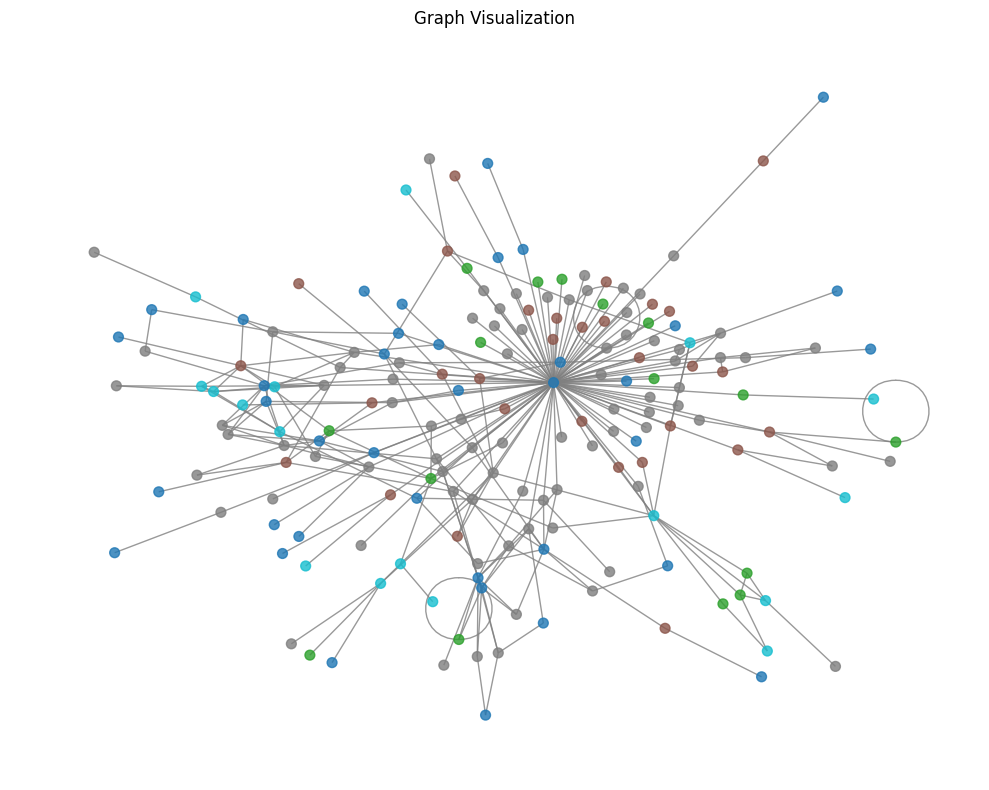

In [6]:
def visualize_graph(data, title="Graph Visualization"):
    G = to_networkx(data, to_undirected=True)
    
    plt.figure(figsize=(10, 8))
    
    pos = nx.spring_layout(G, seed=SEED)
    
    node_colors = data.y.numpy()
    
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color=node_colors,
        cmap=plt.cm.tab10,
        node_size=50,
        edge_color='gray',
        alpha=0.8
    )
        
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_graph(data)


Graph Metrics and Statistics:
 
Average degree: 3.06
Average clustering coefficient: 0.1671
Number of connected components: 1
Largest component size: 183
Graph density: 0.016814


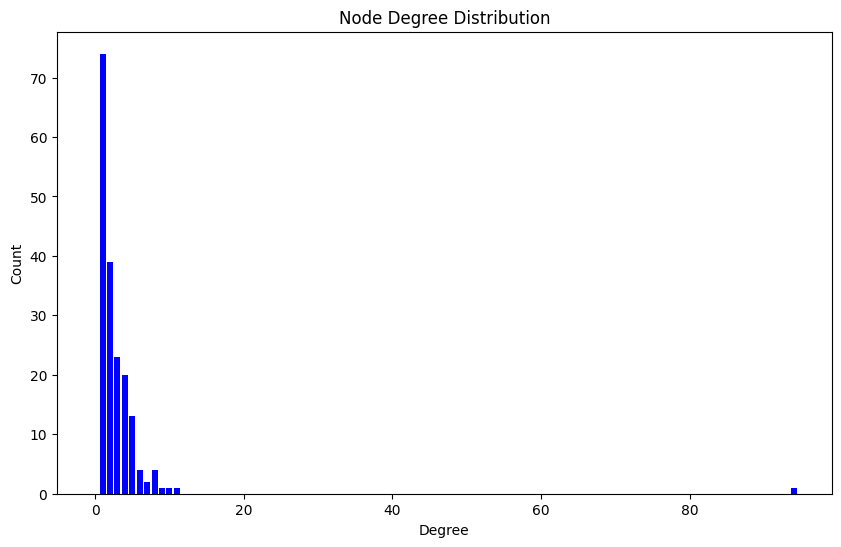

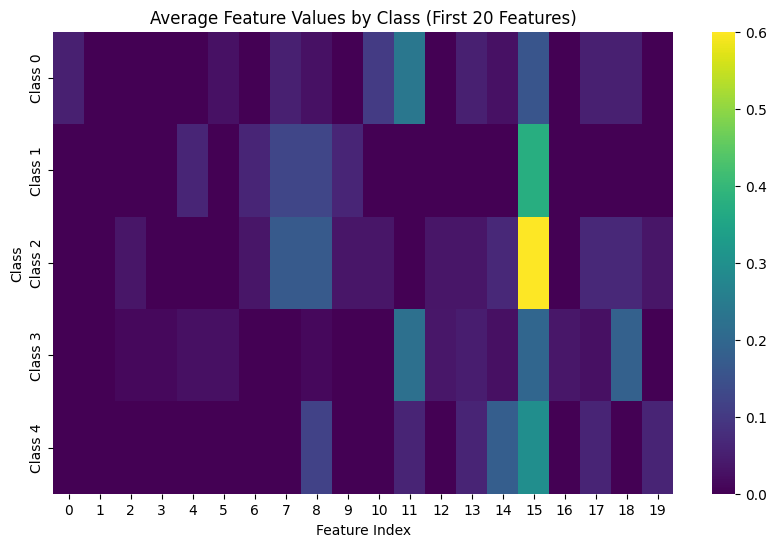

In [7]:
def calculate_graph_metrics(data):
    print("\nGraph Metrics and Statistics:")
    print(" ")
    
    G = to_networkx(data, to_undirected=True)
    
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")
    
    try:
        num_components = nx.number_connected_components(G)
        print(f"Number of connected components: {num_components}")
        
        components = list(nx.connected_components(G))
        largest_component_size = len(max(components, key=len))
        print(f"Largest component size: {largest_component_size}")
        print(f"Graph density: {nx.density(G):.6f}")
    except:
        print("Could not calculate some metrics - graph may be too large")
    
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = np.bincount(degree_sequence)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_count)), degree_count, width=0.80, color='b')
    plt.title("Node Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    
    class_feature_means = []
    for cls in range(dataset.num_classes):
        mask = data.y == cls
        if mask.sum() > 0:
            class_mean = data.x[mask].mean(dim=0)
            class_feature_means.append(class_mean.numpy())
    
    if class_feature_means:
        class_feature_means = np.array(class_feature_means)
        feature_limit = min(20, class_feature_means.shape[1])
        sns.heatmap(
            class_feature_means[:, :feature_limit],
            annot=False,
            cmap='viridis',
            xticklabels=range(feature_limit),
            yticklabels=[f"Class {i}" for i in range(len(class_feature_means))]
        )
        plt.title("Average Feature Values by Class (First 20 Features)")
        plt.xlabel("Feature Index")
        plt.ylabel("Class")
        plt.show()

calculate_graph_metrics(data)


Homophily Analysis:

Homophily ratio: 0.1309 (39 out of 298 edges connect same-class nodes)

Class-specific connectivity patterns:


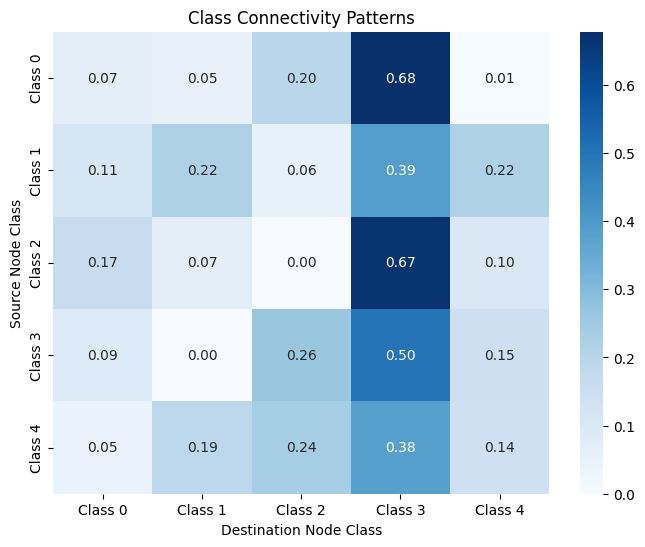

In [8]:
def analyze_homophily(data):
    print("\nHomophily Analysis:\n")
    
    edge_index = data.edge_index
    y = data.y
    num_classes = int(y.max()) + 1

    src_nodes, dst_nodes = edge_index
    same_class_edges = (y[src_nodes] == y[dst_nodes]).sum().item()
    total_edges = edge_index.shape[1]
    
    homophily_ratio = same_class_edges / total_edges
    print(f"Homophily ratio: {homophily_ratio:.4f} ({same_class_edges} out of {total_edges} edges connect same-class nodes)\n")
    
    print("Class-specific connectivity patterns:")
    connection_matrix = np.zeros((num_classes, num_classes))

    for cls in range(num_classes):
        cls_nodes = (y == cls).nonzero(as_tuple=True)[0]
        if len(cls_nodes) == 0:
            continue
        cls_mask = torch.isin(src_nodes, cls_nodes)
        cls_edges = edge_index[:, cls_mask]
        
        if cls_edges.size(1) > 0:
            dst_classes = y[cls_edges[1]]
            dst_class_counts = torch.bincount(dst_classes, minlength=num_classes)
            connection_matrix[cls] = dst_class_counts.numpy() / cls_edges.shape[1]

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        connection_matrix,
        annot=True,
        cmap='Blues',
        xticklabels=[f"Class {i}" for i in range(num_classes)],
        yticklabels=[f"Class {i}" for i in range(num_classes)],
        fmt='.2f'
    )
    plt.title("Class Connectivity Patterns")
    plt.xlabel("Destination Node Class")
    plt.ylabel("Source Node Class")
    plt.show()

analyze_homophily(data)

In [9]:
def split_data(data, val_ratio=0.1, test_ratio=0.2):
    
    transform = RandomNodeSplit(
        num_val=val_ratio,
        num_test=test_ratio
    )
    
    data = transform(data)
    
    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask
    
    print(f"Number of training nodes: {train_mask.sum().item()}")
    print(f"Number of validation nodes: {val_mask.sum().item()}")
    print(f"Number of test nodes: {test_mask.sum().item()}")
    
    return data

data = split_data(data)

Number of training nodes: 128
Number of validation nodes: 18
Number of test nodes: 37


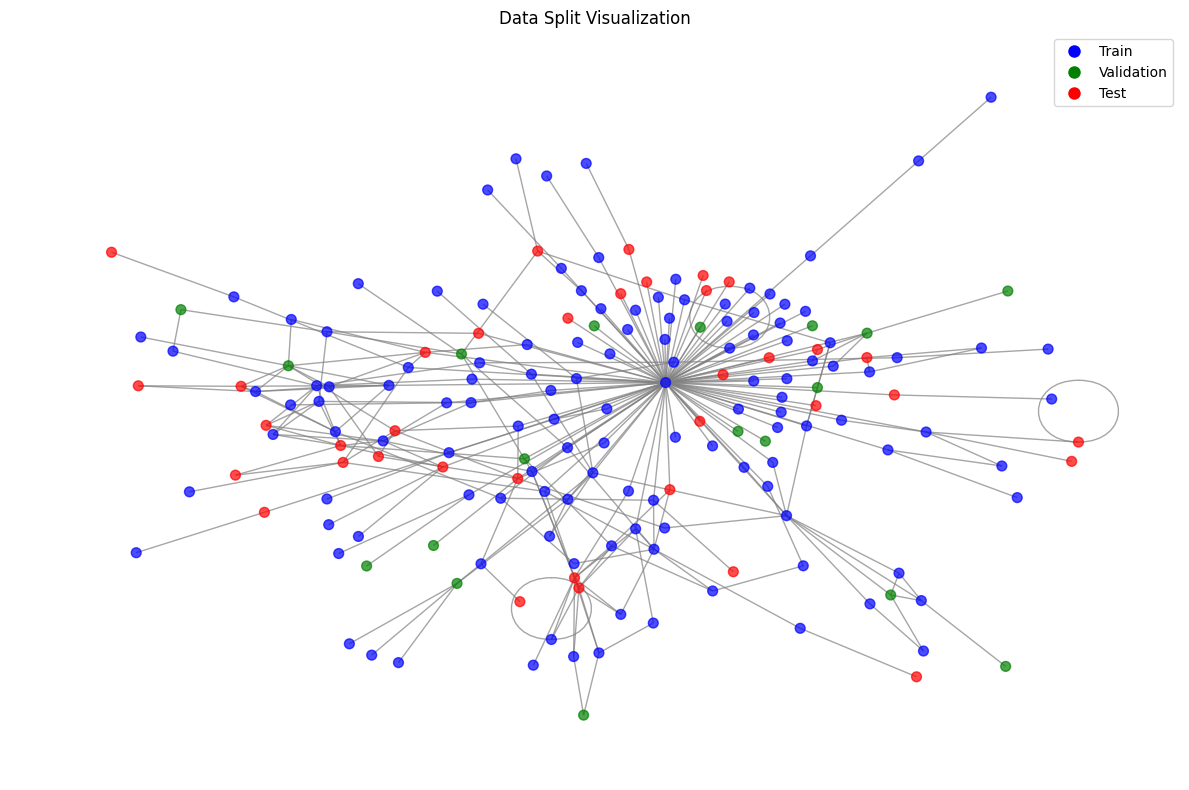

In [10]:
def visualize_split(data):
    G = to_networkx(data, to_undirected=True)
    
    plt.figure(figsize=(12, 8))
    
    pos = nx.spring_layout(G, seed=SEED)
    
    node_colors = []
    for i in range(data.num_nodes):
        if data.train_mask[i]:
            node_colors.append('blue')
        elif data.val_mask[i]:
            node_colors.append('green')
        elif data.test_mask[i]:
            node_colors.append('red')
        else:
            node_colors.append('gray')
    
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color=node_colors,
        node_size=50,
        edge_color='gray',
        alpha=0.7
    )
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Train'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Validation'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Test')
    ]
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("Data Split Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_split(data)

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [12]:
def train_model(model, data, optimizer, epochs=200, early_stopping_patience=20):
    print(f"\n{model.__class__.__name__}...")
    model.train()
    best_val_loss = float('inf')
    best_val_acc = 0
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            train_loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask]).item()
            train_acc = accuracy_score(data.y[data.train_mask].cpu().numpy(), 
                                      out[data.train_mask].argmax(dim=1).cpu().numpy())
            
            val_loss = F.cross_entropy(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy_score(data.y[data.val_mask].cpu().numpy(), 
                                    out[data.val_mask].argmax(dim=1).cpu().numpy())
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation accuracy: {best_val_acc:.4f}")
                model.load_state_dict(best_model_state)
                break
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model.__class__.__name__} - Loss Curves')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model.__class__.__name__} - Accuracy Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, best_val_acc

In [13]:
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        
        test_acc = accuracy_score(data.y[data.test_mask].cpu().numpy(), 
                                 pred[data.test_mask].cpu().numpy())
        
        test_f1 = f1_score(data.y[data.test_mask].cpu().numpy(), 
                          pred[data.test_mask].cpu().numpy(), 
                          average='weighted')
        
        print(f"\nTest Accuracy: {test_acc:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        
        cm = confusion_matrix(data.y[data.test_mask].cpu().numpy(), 
                             pred[data.test_mask].cpu().numpy())
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=[f"Class {i}" for i in range(dataset.num_classes)],
                  yticklabels=[f"Class {i}" for i in range(dataset.num_classes)])
        plt.title(f"{model.__class__.__name__} - Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
        
        return test_acc, test_f1, pred

In [15]:
def visualize_predictions(data, pred, title="Prediction Results"):
    G = to_networkx(data, to_undirected=True)
    
    plt.figure(figsize=(12, 10))
    
    pos = nx.spring_layout(G, seed=SEED)
    
    node_colors = []
    for i in range(data.num_nodes):
        if data.test_mask[i]:
            if pred[i] == data.y[i]:
                node_colors.append('green')
            else:
                node_colors.append('red')
        elif data.train_mask[i]:
            node_colors.append('blue')
        else:
            node_colors.append('gray')
    
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color=node_colors,
        node_size=50,
        edge_color='gray',
        alpha=0.7
    )
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Correct Prediction'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Incorrect Prediction'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Training Node'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Validation Node')
    ]
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
data = data.to(device)

in_channels = data.num_node_features
hidden_channels = 64
out_channels = dataset.num_classes
dropout = 0.5
learning_rate = 0.01
weight_decay = 5e-4

In [17]:
gcn_model = GCN(in_channels, hidden_channels, out_channels, dropout=dropout).to(device)
sage_model = GraphSAGE(in_channels, hidden_channels, out_channels, dropout=dropout).to(device)
gat_model = GAT(in_channels, hidden_channels, out_channels, dropout=dropout).to(device)

gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
sage_optimizer = torch.optim.Adam(sage_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate, weight_decay=weight_decay)


GCN...
Epoch: 010, Train Loss: 0.6803, Val Loss: 2.0260, Train Acc: 0.7656, Val Acc: 0.3333
Epoch: 020, Train Loss: 0.4668, Val Loss: 2.4568, Train Acc: 0.8438, Val Acc: 0.3333
Early stopping at epoch 27. Best validation accuracy: 0.4444


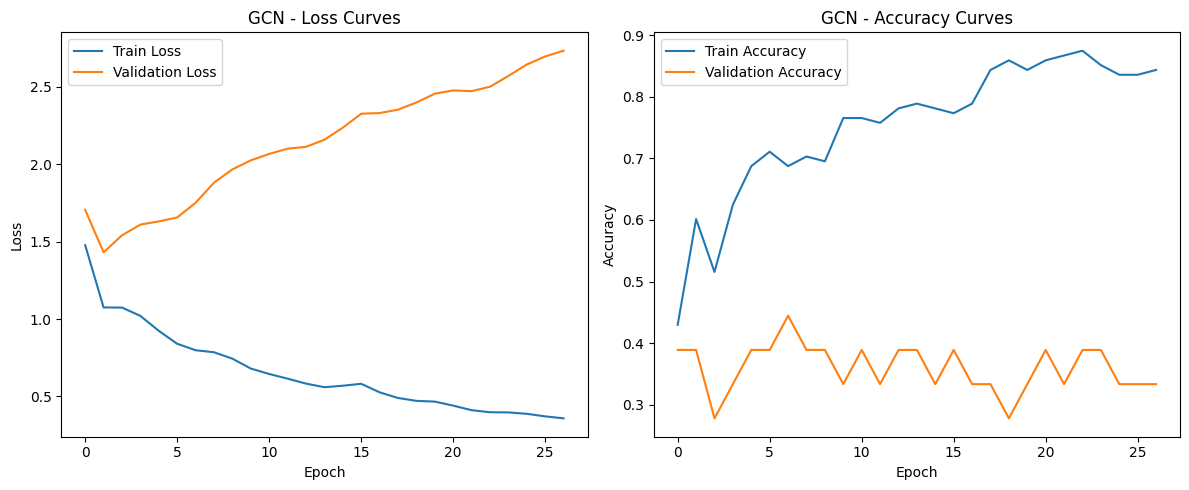


GraphSAGE...
Epoch: 010, Train Loss: 0.1795, Val Loss: 1.1810, Train Acc: 0.9453, Val Acc: 0.6111
Epoch: 020, Train Loss: 0.0378, Val Loss: 1.6029, Train Acc: 0.9922, Val Acc: 0.6667
Epoch: 030, Train Loss: 0.0133, Val Loss: 1.6512, Train Acc: 1.0000, Val Acc: 0.7222
Early stopping at epoch 33. Best validation accuracy: 0.7222


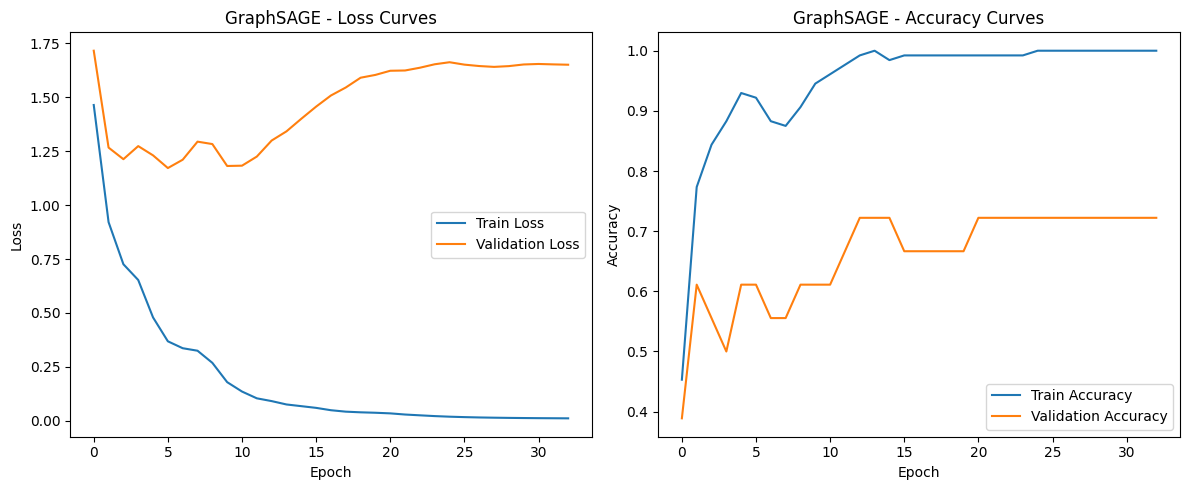


GAT...
Epoch: 010, Train Loss: 0.8746, Val Loss: 2.2343, Train Acc: 0.6953, Val Acc: 0.3333
Epoch: 020, Train Loss: 1.0013, Val Loss: 2.5835, Train Acc: 0.7578, Val Acc: 0.5000
Epoch: 030, Train Loss: 0.7499, Val Loss: 2.6200, Train Acc: 0.7578, Val Acc: 0.3333
Epoch: 040, Train Loss: 0.4901, Val Loss: 3.0330, Train Acc: 0.8125, Val Acc: 0.3889
Early stopping at epoch 42. Best validation accuracy: 0.5556


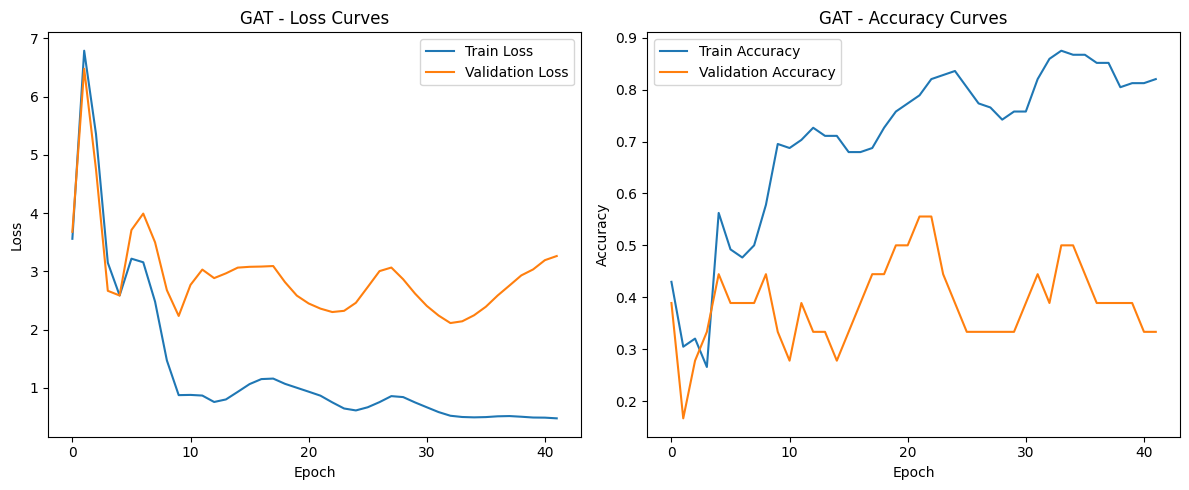

In [18]:
gcn_model, gcn_val_acc = train_model(gcn_model, data, gcn_optimizer)
sage_model, sage_val_acc = train_model(sage_model, data, sage_optimizer)
gat_model, gat_val_acc = train_model(gat_model, data, gat_optimizer)


Model Evaluation:
 

GCN Model:

Test Accuracy: 0.4054
Test F1 Score: 0.3837


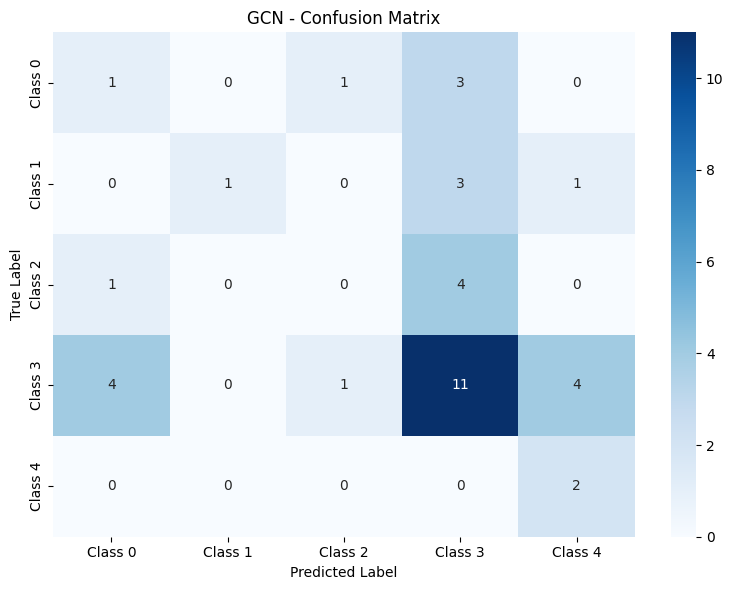


GraphSAGE Model:

Test Accuracy: 0.7838
Test F1 Score: 0.7829


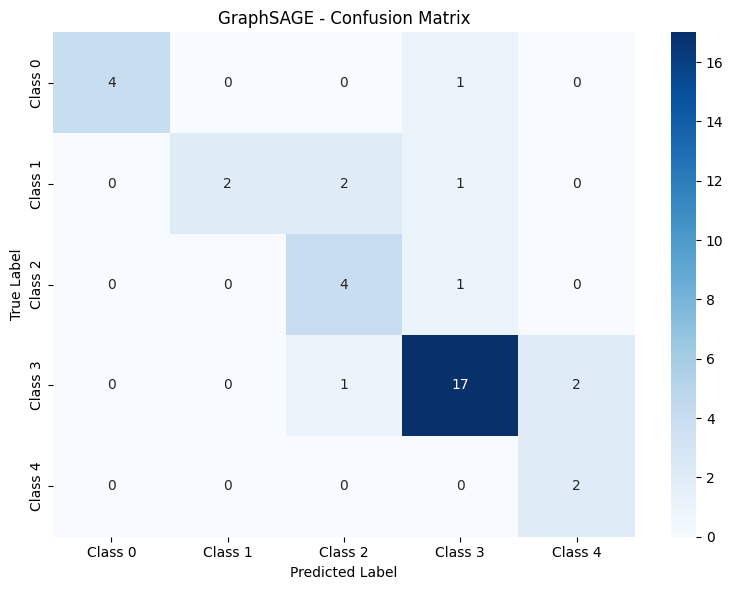


GAT Model:

Test Accuracy: 0.5676
Test F1 Score: 0.5463


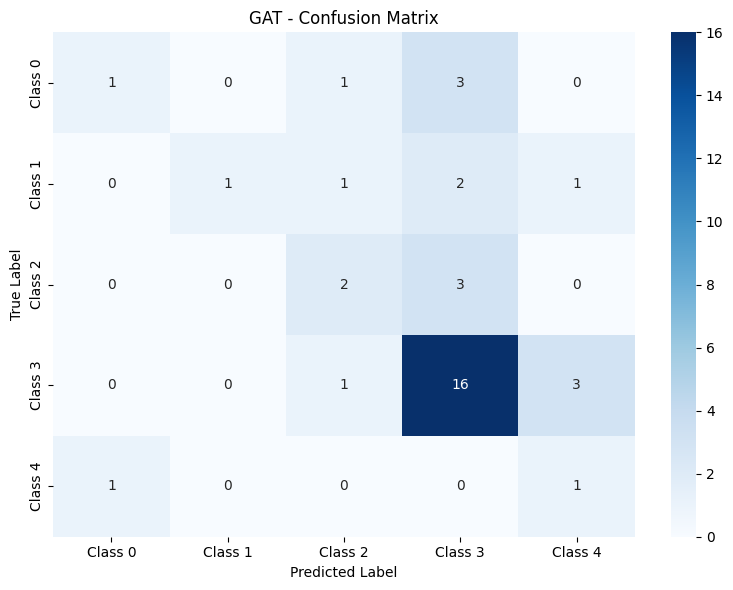

In [19]:
print("\nModel Evaluation:")
print(" ")

print("\nGCN Model:")
gcn_test_acc, gcn_test_f1, gcn_pred = evaluate_model(gcn_model, data)

print("\nGraphSAGE Model:")
sage_test_acc, sage_test_f1, sage_pred = evaluate_model(sage_model, data)

print("\nGAT Model:")
gat_test_acc, gat_test_f1, gat_pred = evaluate_model(gat_model, data)


Model Comparison:
----------------------------------------
       Model  Validation Accuracy  Test Accuracy  Test F1 Score
0        GCN             0.444444       0.405405       0.383685
1  GraphSAGE             0.722222       0.783784       0.782926
2        GAT             0.555556       0.567568       0.546274


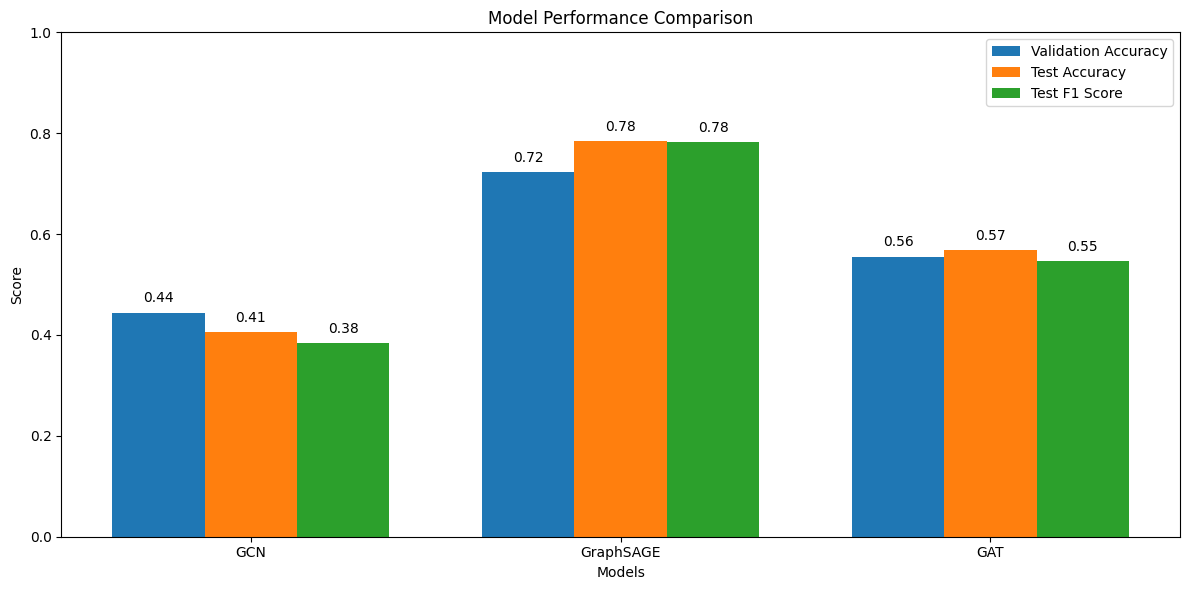

In [20]:
def compare_models():
    print("\nModel Comparison:")
    print("-" * 40)
    
    models = ['GCN', 'GraphSAGE', 'GAT']
    val_accs = [gcn_val_acc, sage_val_acc, gat_val_acc]
    test_accs = [gcn_test_acc, sage_test_acc, gat_test_acc]
    test_f1s = [gcn_test_f1, sage_test_f1, gat_test_f1]
    
    results_df = pd.DataFrame({
        'Model': models,
        'Validation Accuracy': val_accs,
        'Test Accuracy': test_accs,
        'Test F1 Score': test_f1s
    })
    
    print(results_df)
    
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(models))
    width = 0.25
    
    plt.bar(x - width, val_accs, width, label='Validation Accuracy')
    plt.bar(x, test_accs, width, label='Test Accuracy')
    plt.bar(x + width, test_f1s, width, label='Test F1 Score')
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models)
    plt.legend()
    plt.ylim(0, 1)
    
    for i, v in enumerate(val_accs):
        plt.text(i - width, v + 0.02, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(test_accs):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
        
    for i, v in enumerate(test_f1s):
        plt.text(i + width, v + 0.02, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

compare_models()

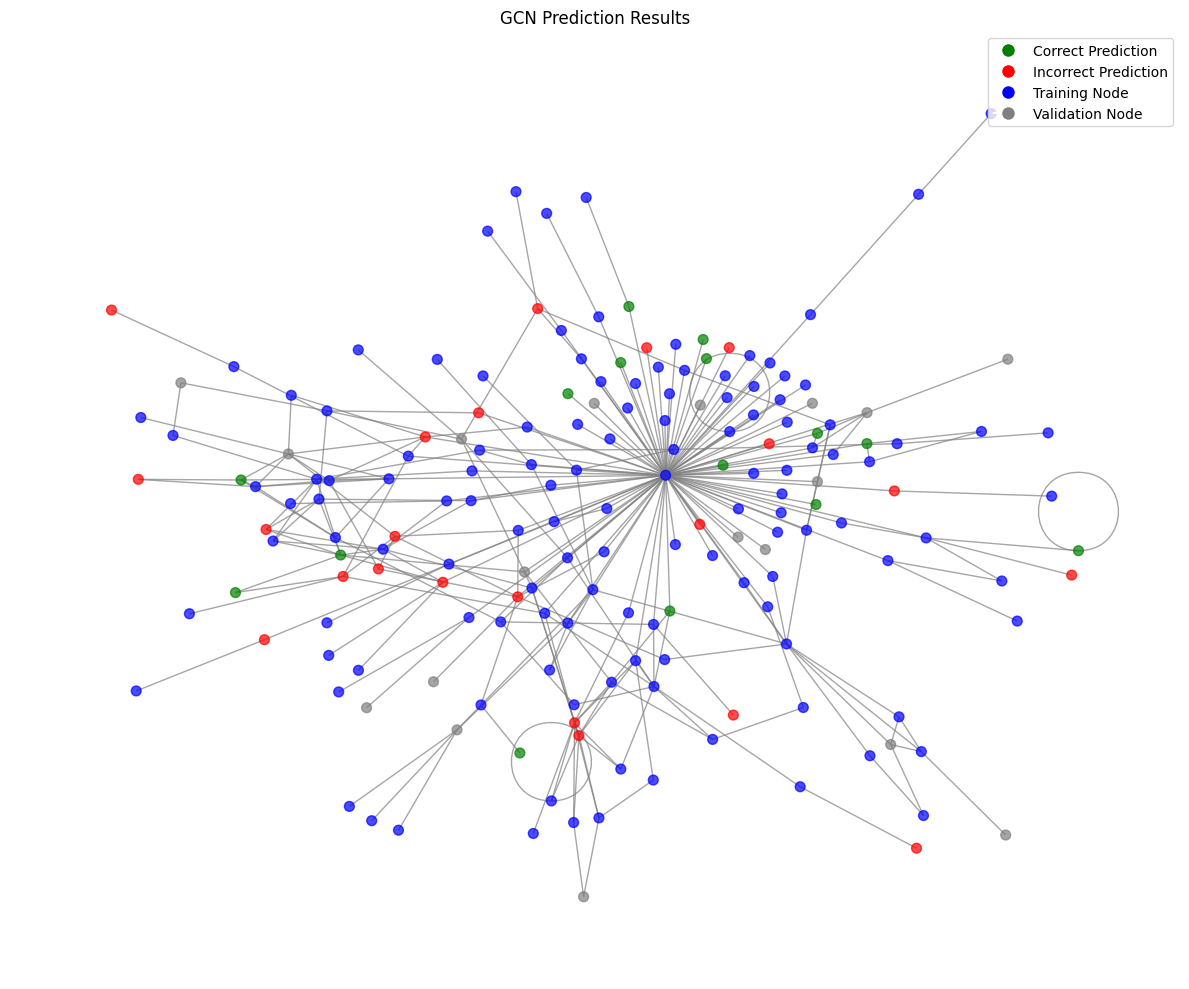

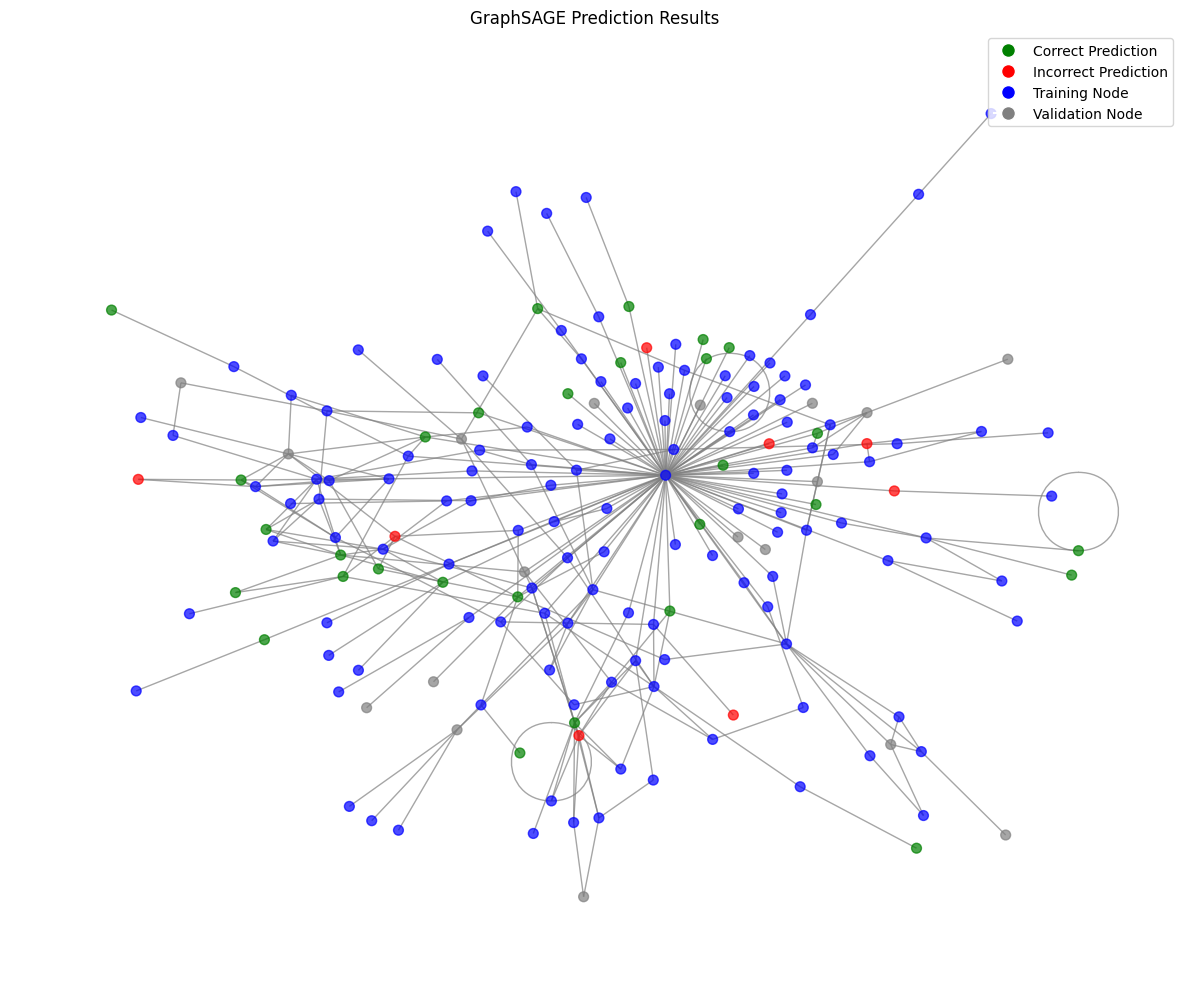

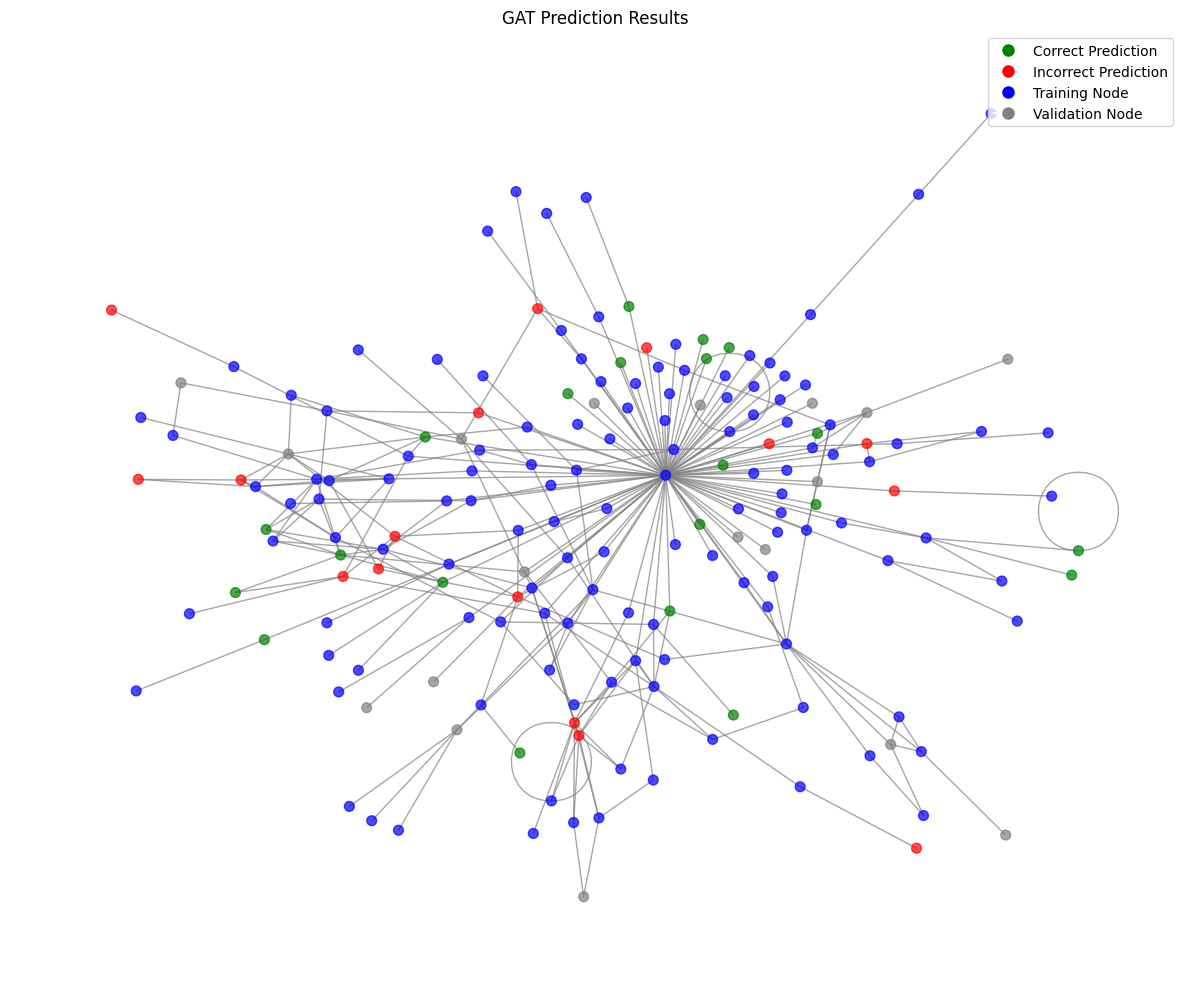

In [22]:
visualize_predictions(data, gcn_pred, title="GCN Prediction Results")
visualize_predictions(data, sage_pred, title="GraphSAGE Prediction Results")
visualize_predictions(data, gat_pred, title="GAT Prediction Results")


Hyperparameter Tuning:
 
Tuning hyperparameters for the best model: GraphSAGE

Testing with learning rate=0.001, dropout=0.3

GraphSAGE...
Epoch: 010, Train Loss: 0.7338, Val Loss: 1.1876, Train Acc: 0.7734, Val Acc: 0.6111
Early stopping at epoch 19. Best validation accuracy: 0.6111


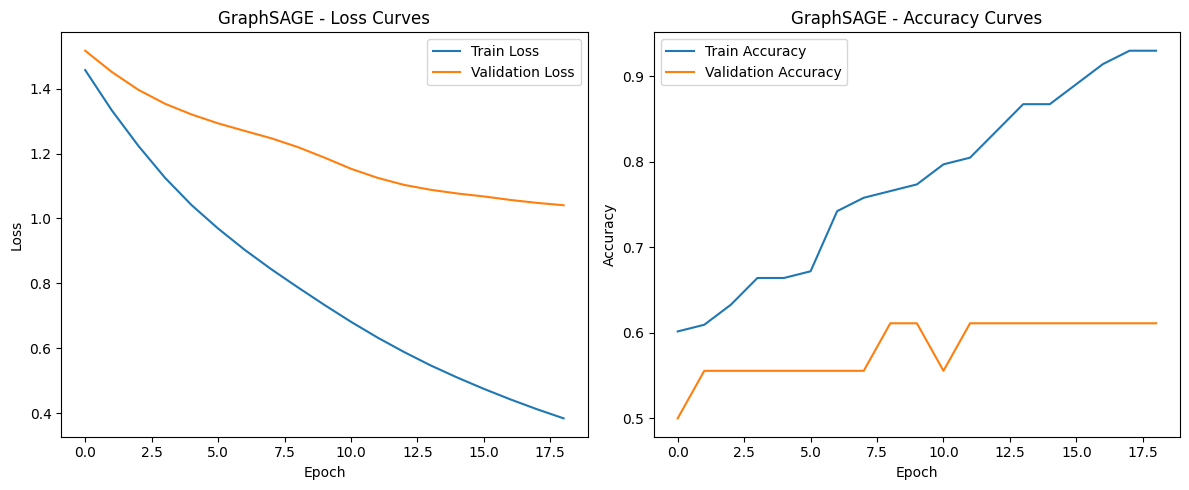


Testing with learning rate=0.001, dropout=0.5

GraphSAGE...
Epoch: 010, Train Loss: 0.8081, Val Loss: 1.2289, Train Acc: 0.7812, Val Acc: 0.5556
Epoch: 020, Train Loss: 0.4386, Val Loss: 1.1345, Train Acc: 0.8906, Val Acc: 0.6111
Early stopping at epoch 21. Best validation accuracy: 0.6667


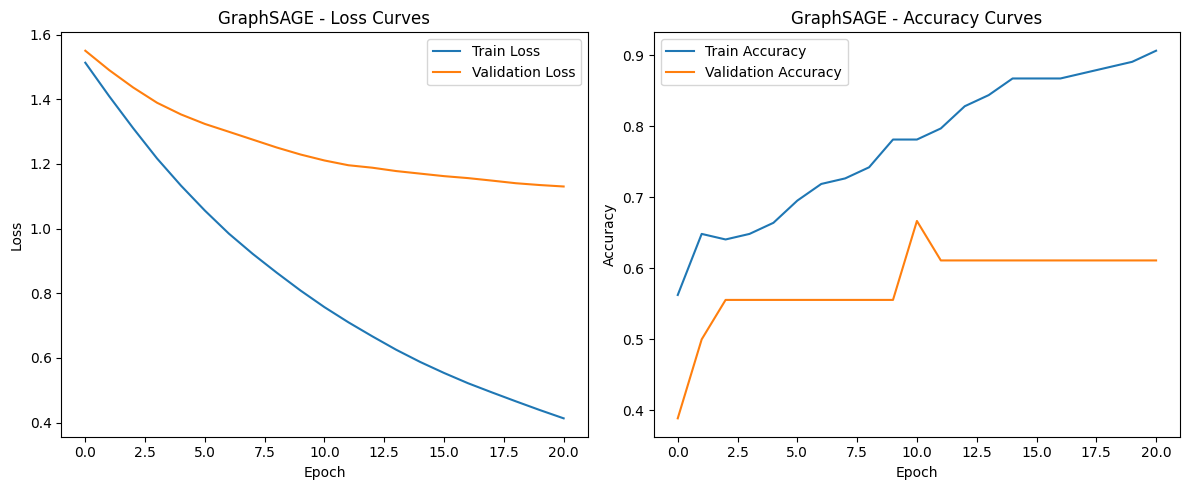


Testing with learning rate=0.001, dropout=0.7

GraphSAGE...
Epoch: 010, Train Loss: 0.8661, Val Loss: 1.2606, Train Acc: 0.7734, Val Acc: 0.5556
Epoch: 020, Train Loss: 0.5280, Val Loss: 1.0912, Train Acc: 0.8828, Val Acc: 0.6111
Early stopping at epoch 24. Best validation accuracy: 0.6667


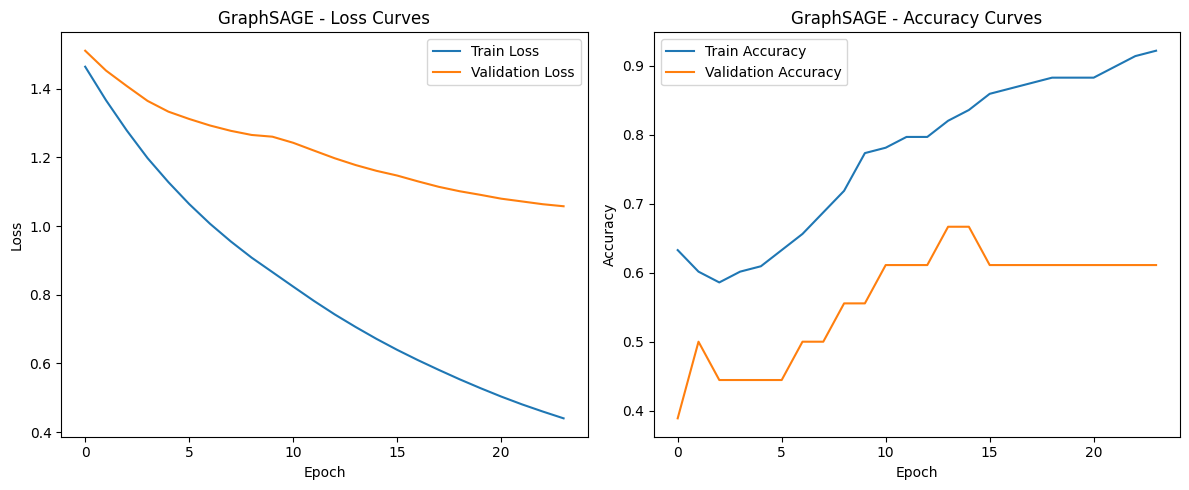


Testing with learning rate=0.005, dropout=0.3

GraphSAGE...
Epoch: 010, Train Loss: 0.1404, Val Loss: 1.2542, Train Acc: 0.9609, Val Acc: 0.6667
Early stopping at epoch 13. Best validation accuracy: 0.6667


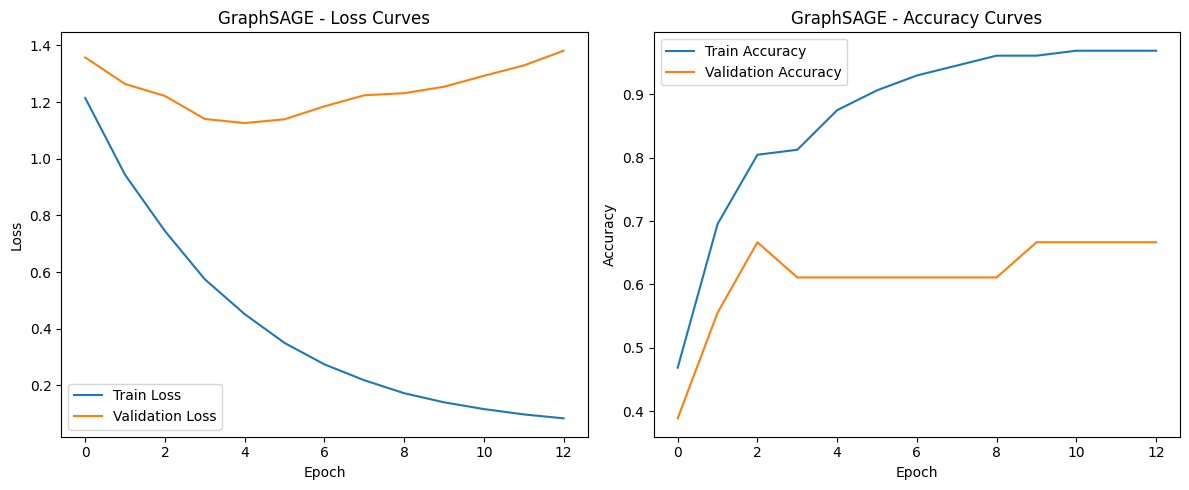


Testing with learning rate=0.005, dropout=0.5

GraphSAGE...
Epoch: 010, Train Loss: 0.2222, Val Loss: 1.0300, Train Acc: 0.9609, Val Acc: 0.6667
Epoch: 020, Train Loss: 0.0573, Val Loss: 1.1977, Train Acc: 0.9922, Val Acc: 0.7222
Early stopping at epoch 26. Best validation accuracy: 0.7778


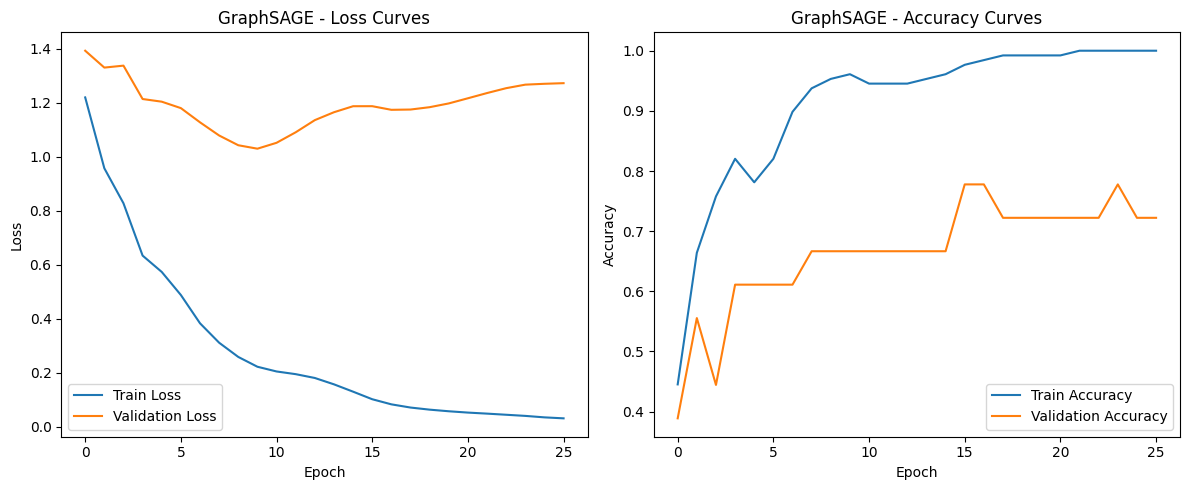


Testing with learning rate=0.005, dropout=0.7

GraphSAGE...
Epoch: 010, Train Loss: 0.3401, Val Loss: 1.0384, Train Acc: 0.9141, Val Acc: 0.6111
Early stopping at epoch 13. Best validation accuracy: 0.6667


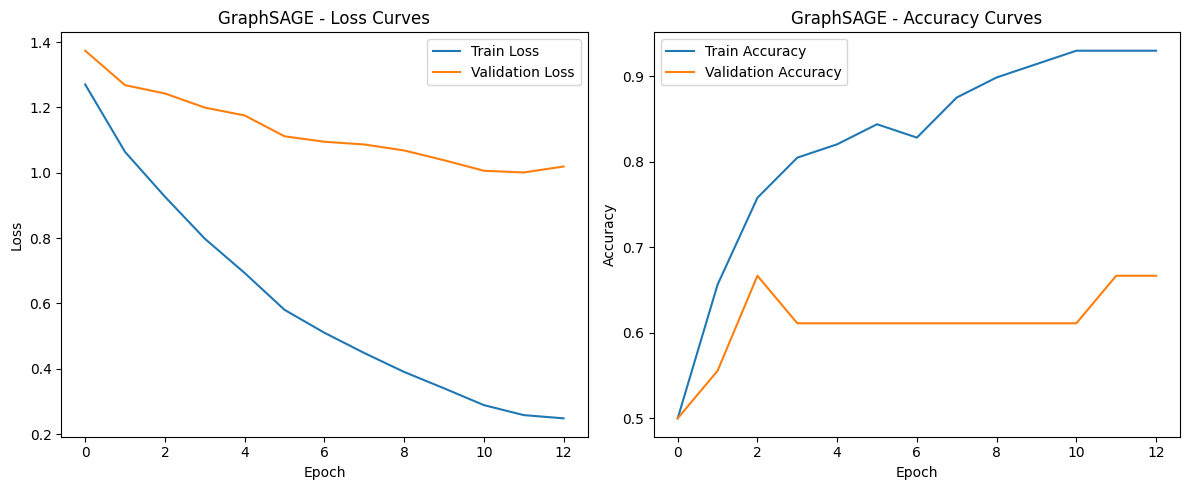


Testing with learning rate=0.01, dropout=0.3

GraphSAGE...
Epoch: 010, Train Loss: 0.1214, Val Loss: 1.2891, Train Acc: 0.9688, Val Acc: 0.6667
Epoch: 020, Train Loss: 0.0290, Val Loss: 1.7200, Train Acc: 0.9922, Val Acc: 0.7222
Early stopping at epoch 27. Best validation accuracy: 0.7778


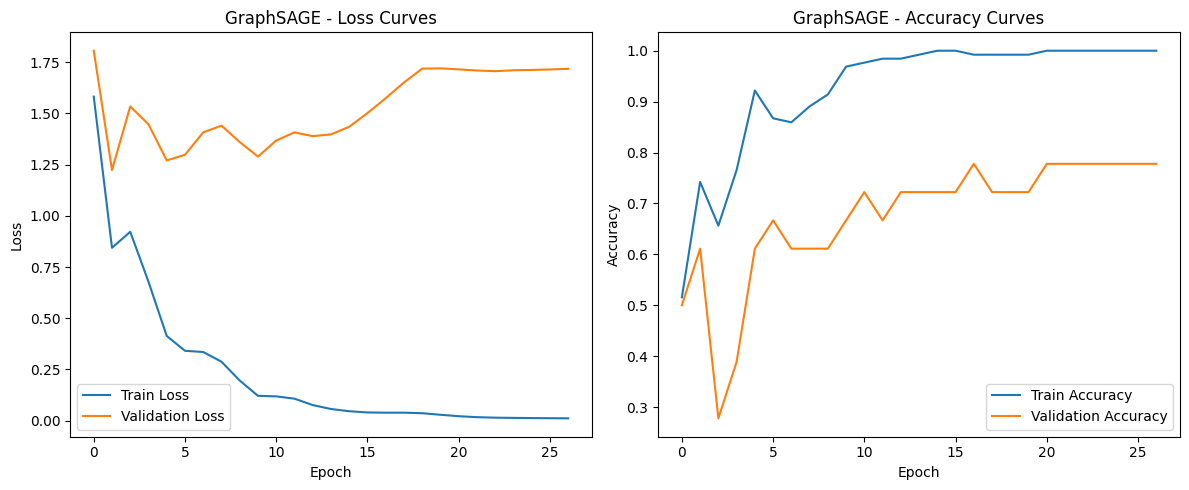


Testing with learning rate=0.01, dropout=0.5

GraphSAGE...
Epoch: 010, Train Loss: 0.2007, Val Loss: 0.9611, Train Acc: 0.9375, Val Acc: 0.6667
Epoch: 020, Train Loss: 0.0462, Val Loss: 1.2245, Train Acc: 0.9844, Val Acc: 0.7778
Epoch: 030, Train Loss: 0.0125, Val Loss: 1.2608, Train Acc: 1.0000, Val Acc: 0.7778
Early stopping at epoch 34. Best validation accuracy: 0.8333


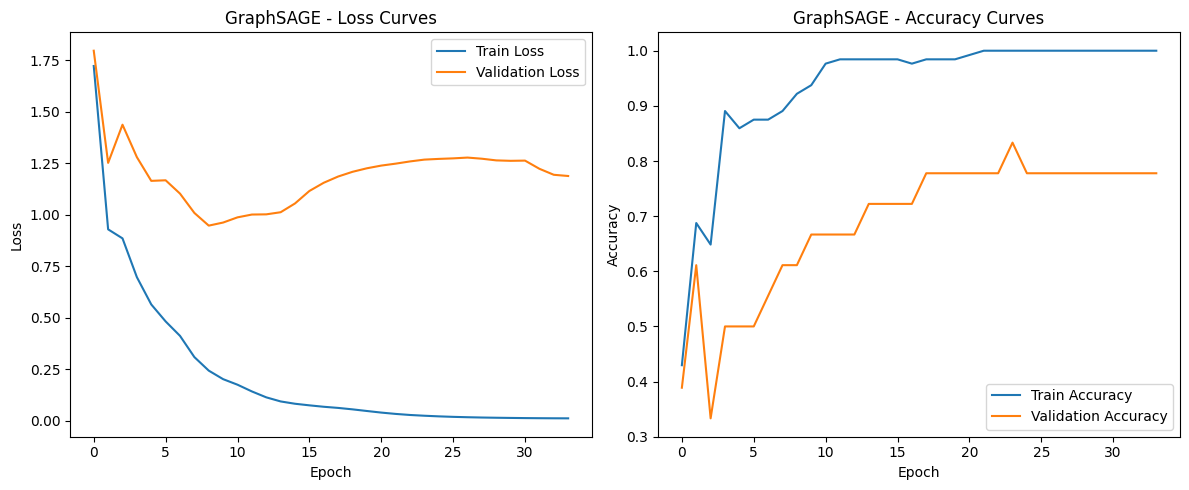


Testing with learning rate=0.01, dropout=0.7

GraphSAGE...
Epoch: 010, Train Loss: 0.2805, Val Loss: 1.1436, Train Acc: 0.9297, Val Acc: 0.6111
Epoch: 020, Train Loss: 0.0797, Val Loss: 1.1067, Train Acc: 0.9922, Val Acc: 0.7222
Epoch: 030, Train Loss: 0.0352, Val Loss: 1.2279, Train Acc: 1.0000, Val Acc: 0.7778
Epoch: 040, Train Loss: 0.0204, Val Loss: 1.3182, Train Acc: 1.0000, Val Acc: 0.7778
Early stopping at epoch 41. Best validation accuracy: 0.8333


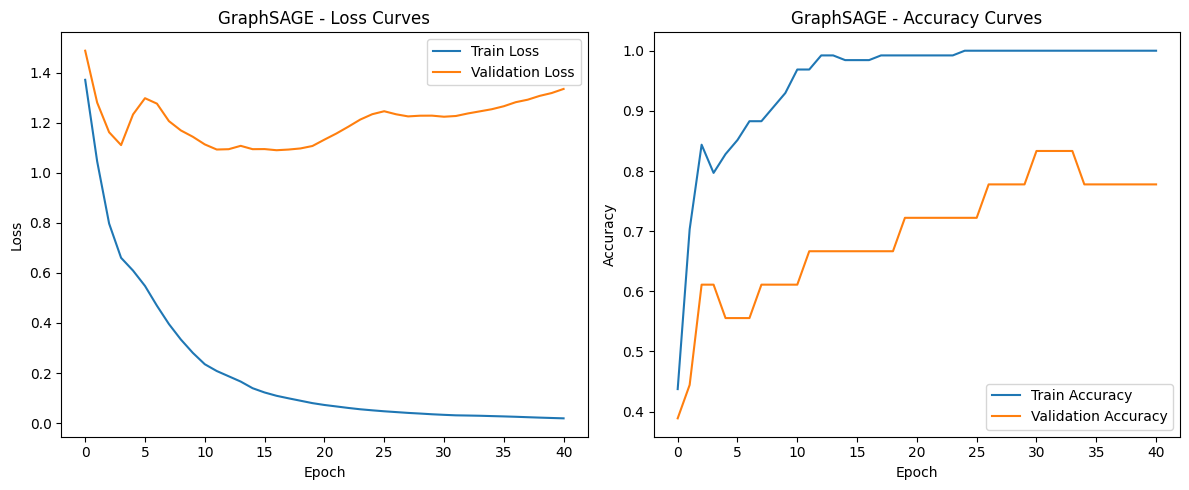


Testing with learning rate=0.05, dropout=0.3

GraphSAGE...
Epoch: 010, Train Loss: 1.0841, Val Loss: 4.3653, Train Acc: 0.7969, Val Acc: 0.4444
Epoch: 020, Train Loss: 0.0706, Val Loss: 2.4583, Train Acc: 0.9766, Val Acc: 0.7222
Epoch: 030, Train Loss: 0.0421, Val Loss: 2.3177, Train Acc: 0.9922, Val Acc: 0.6667
Early stopping at epoch 31. Best validation accuracy: 0.7778


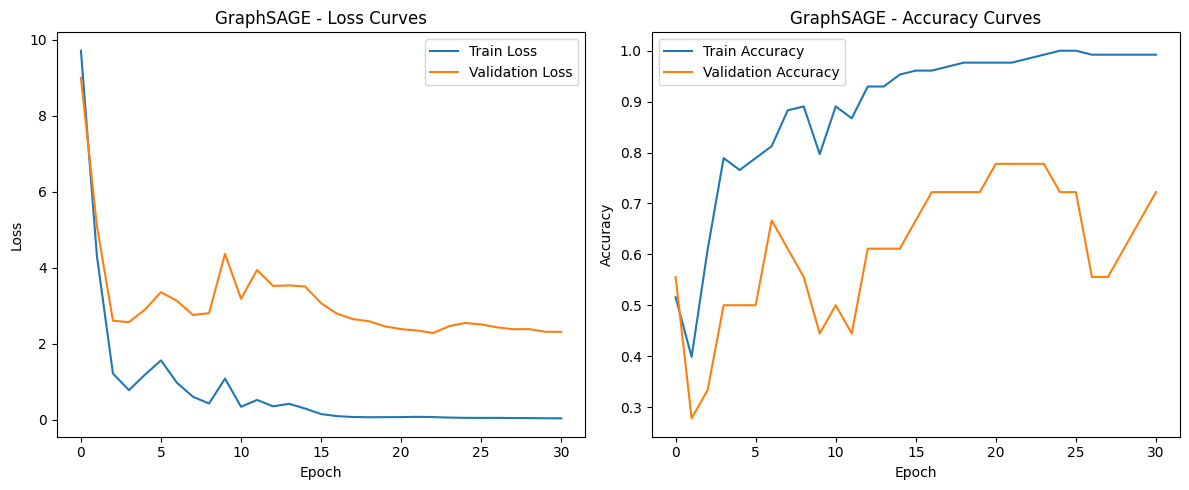


Testing with learning rate=0.05, dropout=0.5

GraphSAGE...
Epoch: 010, Train Loss: 0.2639, Val Loss: 0.7141, Train Acc: 0.8906, Val Acc: 0.7222
Epoch: 020, Train Loss: 0.1353, Val Loss: 2.2929, Train Acc: 0.9531, Val Acc: 0.5556
Early stopping at epoch 23. Best validation accuracy: 0.7778


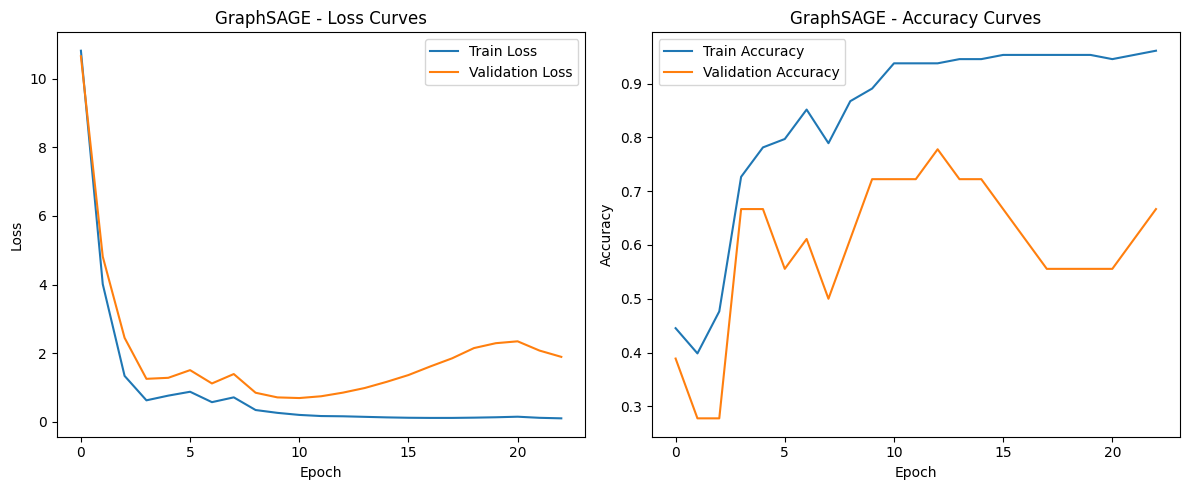


Testing with learning rate=0.05, dropout=0.7

GraphSAGE...
Epoch: 010, Train Loss: 0.8424, Val Loss: 2.3253, Train Acc: 0.7969, Val Acc: 0.6111
Epoch: 020, Train Loss: 0.3082, Val Loss: 1.6522, Train Acc: 0.8828, Val Acc: 0.6111
Early stopping at epoch 27. Best validation accuracy: 0.6667


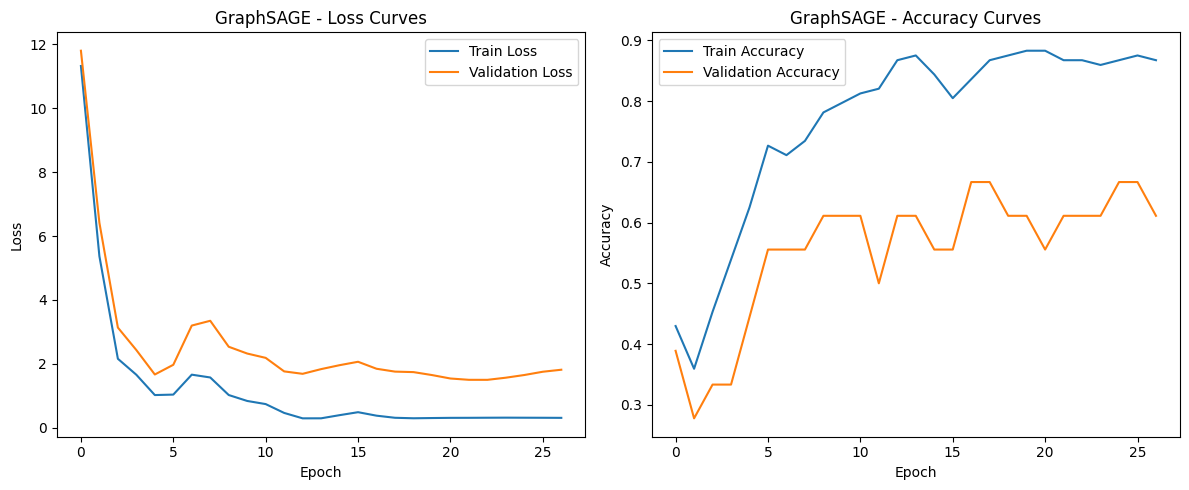


Hyperparameter tuning results:
    learning_rate  dropout   val_acc  test_acc
0           0.001      0.3  0.611111  0.702703
1           0.001      0.5  0.666667  0.675676
2           0.001      0.7  0.666667  0.702703
3           0.005      0.3  0.666667  0.702703
4           0.005      0.5  0.777778  0.783784
5           0.005      0.7  0.666667  0.729730
6           0.010      0.3  0.777778  0.729730
7           0.010      0.5  0.833333  0.729730
8           0.010      0.7  0.833333  0.729730
9           0.050      0.3  0.777778  0.729730
10          0.050      0.5  0.777778  0.702703
11          0.050      0.7  0.666667  0.729730

Best hyperparameters:
Learning Rate: 0.01
Dropout: 0.5
Validation Accuracy: 0.8333
Test Accuracy: 0.7297


In [24]:
def hyperparameter_tuning():
    print("\nHyperparameter Tuning:")
    print(" ")
    
    val_accs = [gcn_val_acc, sage_val_acc, gat_val_acc]
    best_model_idx = val_accs.index(max(val_accs))
    best_model_name = ['GCN', 'GraphSAGE', 'GAT'][best_model_idx]
    
    print(f"Tuning hyperparameters for the best model: {best_model_name}")
    
    learning_rates = [0.001, 0.005, 0.01, 0.05]
    dropouts = [0.3, 0.5, 0.7]
    
    results = []
    
    for lr in learning_rates:
        for dr in dropouts:
            print(f"\nTesting with learning rate={lr}, dropout={dr}")
            
            if best_model_name == 'GCN':
                model = GCN(in_channels, hidden_channels, out_channels, dropout=dr).to(device)
            elif best_model_name == 'GraphSAGE':
                model = GraphSAGE(in_channels, hidden_channels, out_channels, dropout=dr).to(device)
            else:
                model = GAT(in_channels, hidden_channels, out_channels, dropout=dr).to(device)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            
            model, val_acc = train_model(model, data, optimizer, epochs=100, early_stopping_patience=10)
            
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index)
                pred = out.argmax(dim=1)
                test_acc = accuracy_score(data.y[data.test_mask].cpu().numpy(), 
                                         pred[data.test_mask].cpu().numpy())
            
            results.append({
                'learning_rate': lr,
                'dropout': dr,
                'val_acc': val_acc,
                'test_acc': test_acc
            })
    
    results_df = pd.DataFrame(results)
    print("\nHyperparameter tuning results:")
    print(results_df)
    
    best_result = results_df.loc[results_df['val_acc'].idxmax()]
    print(f"\nBest hyperparameters:")
    print(f"Learning Rate: {best_result['learning_rate']}")
    print(f"Dropout: {best_result['dropout']}")
    print(f"Validation Accuracy: {best_result['val_acc']:.4f}")
    print(f"Test Accuracy: {best_result['test_acc']:.4f}")
      
    return best_result

best_hyper_result = hyperparameter_tuning()

Model: GraphSAGE
Learning Rate: 0.01
Dropout: 0.5

GraphSAGE...
Epoch: 010, Train Loss: 0.1068, Val Loss: 1.1304, Train Acc: 0.9766, Val Acc: 0.6667
Epoch: 020, Train Loss: 0.0214, Val Loss: 1.2601, Train Acc: 1.0000, Val Acc: 0.7222
Epoch: 030, Train Loss: 0.0119, Val Loss: 1.2868, Train Acc: 1.0000, Val Acc: 0.8333
Epoch: 040, Train Loss: 0.0093, Val Loss: 1.5217, Train Acc: 1.0000, Val Acc: 0.7222
Early stopping at epoch 43. Best validation accuracy: 0.8333


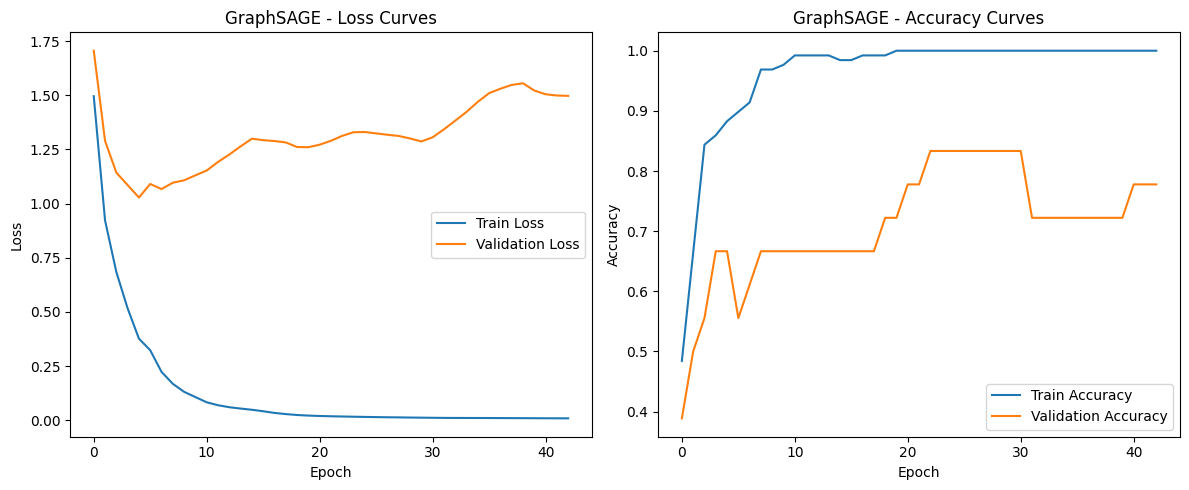


Test Accuracy: 0.7027
Test F1 Score: 0.6706


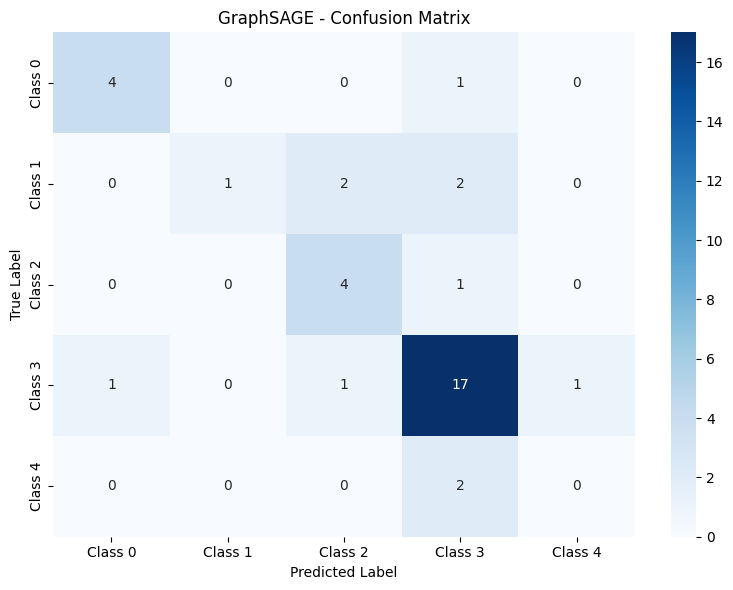

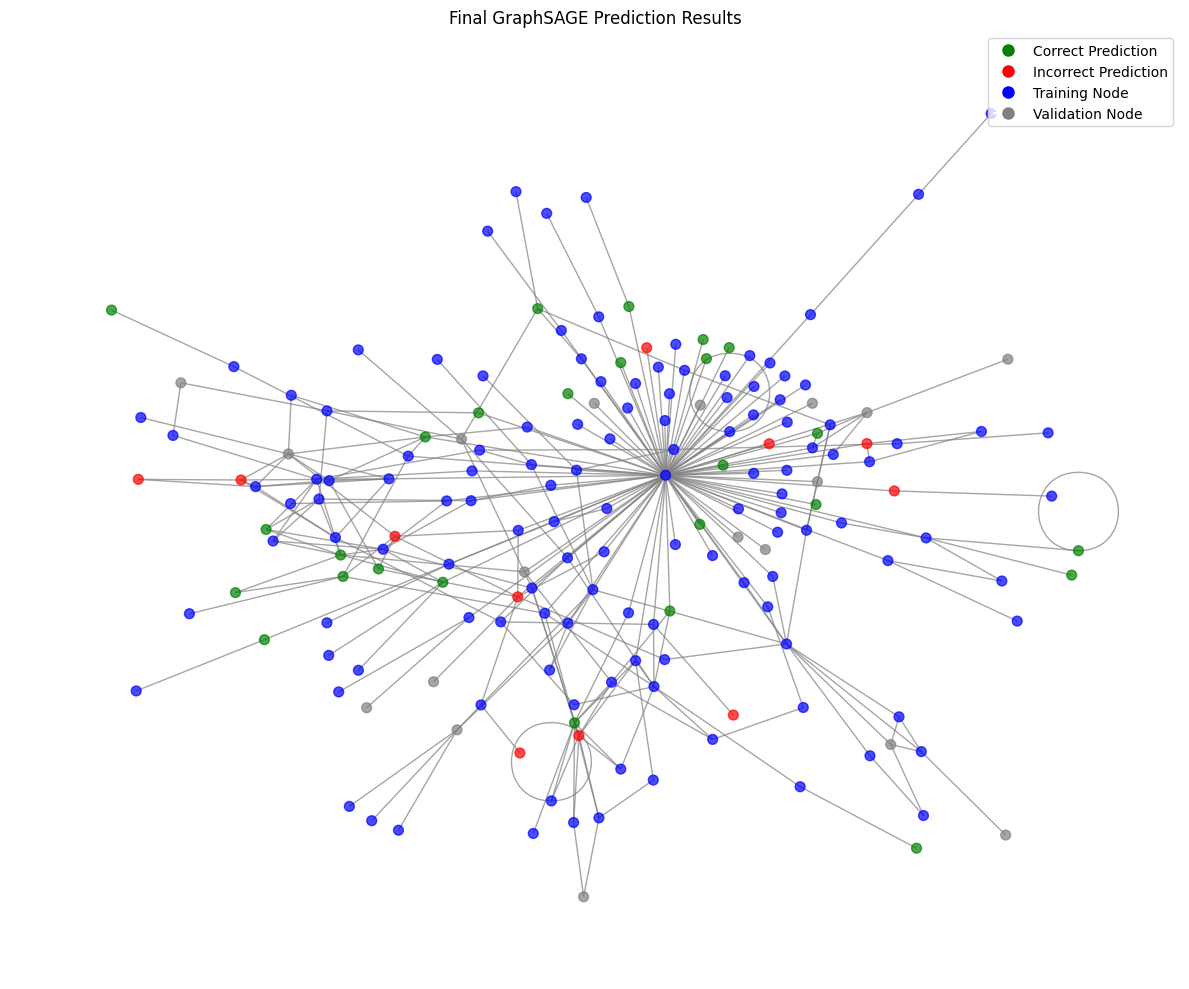

In [25]:
def train_final_model(data, model_name, best_hyper_result):

    best_lr = best_hyper_result['learning_rate']
    best_dropout = best_hyper_result['dropout']
    
    print(f"Model: {model_name}")
    print(f"Learning Rate: {best_lr}")
    print(f"Dropout: {best_dropout}")
    
    if model_name == 'GCN':
        model = GCN(in_channels, hidden_channels, out_channels, dropout=best_dropout).to(device)
    elif model_name == 'GraphSAGE':
        model = GraphSAGE(in_channels, hidden_channels, out_channels, dropout=best_dropout).to(device)
    else:
        model = GAT(in_channels, hidden_channels, out_channels, dropout=best_dropout).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
    
    model, val_acc = train_model(model, data, optimizer, epochs=200, early_stopping_patience=20)
    
    test_acc, test_f1, predictions = evaluate_model(model, data)
    
    visualize_predictions(data, predictions, title=f"Final {model_name} Prediction Results")
    
    return model, predictions, test_acc, test_f1

val_accs = [gcn_val_acc, sage_val_acc, gat_val_acc]
best_model_idx = val_accs.index(max(val_accs))
best_model_name = ['GCN', 'GraphSAGE', 'GAT'][best_model_idx]

final_model, final_predictions, final_test_acc, final_test_f1 = train_final_model(
    data, best_model_name, best_hyper_result
)